## Test the Stability of the Model
In this experiment, we check the stability of the model by performing the following experiments: 
1. Remove 5%, 10%, 20%, 30%, and 50% of data randomly from the training set and evaluate the testing performance

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pickle import load, dump

sys.path.insert(0, '../')

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.base import clone
from sklearn.metrics import r2_score

from src.load_dataset import load_dataset
from src.utils import tsen_pca_viz, verify_batch_label_dist, calculate_r2_score, calculate_per_diff, per_error, find_adj_score, perform_combat_normalization
from src.load_models import select_model
from src.graph_visualization import visualization_testing_dataset
from src.config import *

In [2]:
# Load dataset
normalization    = True
standardize_type = 'mean_std' if normalization else 'none'
split            = False
combat_norm      = True

ML1_X, ML1_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1', normalization=normalization, standardize_type=standardize_type, split=split)
ML2_X, ML2_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_22_ML2', normalization=normalization, standardize_type=standardize_type, split=split)
ML4_X, ML4_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4', normalization=normalization, standardize_type=standardize_type, split=split)

In [3]:
# Perform stratified train test split
X                = pd.concat([ML1_X, ML2_X, ML4_X], axis=0)
y                = ML1_y.values.tolist() + ML2_y.values.tolist() + ML4_y.values.tolist()
stratified_label = ML1_y.map(lambda x: f'ML1_{x}').values.tolist() + ML2_y.map(lambda x: f'ML2_{x}').values.tolist() + ML4_y.map(lambda x: f'ML4_{x}').values.tolist()

X_train, X_test, y_train_strat, y_test_strat = train_test_split(X, stratified_label, test_size=0.4, shuffle=True, random_state=20, stratify=stratified_label)
y_train, y_test = pd.Series(y_train_strat).map(lambda x: eval(x.split('_')[1])), pd.Series(y_test_strat).map(lambda x: eval(x.split('_')[1]))

In [24]:
def plot_scores_distribution(scores, model_name, adj_score=False):
    scores = scores.copy()
    if type(scores[0][model_name][0])==tuple:
        for data_per_remove in per_to_remove:
            scores[data_per_remove][model_name] = np.array(scores[data_per_remove][model_name])[:,(1 if adj_score else 0)]
    for data_per_remove in per_to_remove:
        sns.kdeplot(scores[data_per_remove][model_name], label=f'{data_per_remove}%')
    
    plt.legend(title='Parameter', title_fontsize='13')
    plt.show()


def training_reduction_plot(scores, model_names, r2=True, adj_score=False):

    min_, max_ = (0.70 if r2 else 10), (0.9 if r2 else 60)
    
    for model_name in model_names:
        data = []
        if type(scores[0][model_name][0])==tuple:
            for data_per_remove in per_to_remove:
                scores[data_per_remove][model_name] = np.array(scores[data_per_remove][model_name])[:,(1 if adj_score else 0)]
    
        for data_per_remove in per_to_remove:
            data.append(np.array(scores[data_per_remove][model_name]).mean())
            
        # plt.ylim(bottom=min_, top=max_)
        plt.plot(data, label=model_name)
        plt.xticks(ticks=range(len(per_to_remove)), labels=[f'{i}%' for i in per_to_remove])
        plt.legend()
        
    plt.show()

def box_plot(scores, model_names, adj_score=False):
    for model_name in model_names:
        data = pd.DataFrame(columns=['scores', 'per_remove'])
    
        for data_per_remove in per_to_remove:
            if type(scores[data_per_remove][model_name][0])==tuple:
                scores[data_per_remove][model_name] = np.array(scores[data_per_remove][model_name])[:, (1 if adj_score else 0)]
                
            temp = pd.DataFrame({'scores':np.array(scores[data_per_remove][model_name]).tolist(), 'per_remove':[f'{data_per_remove}%']*len(scores[data_per_remove][model_name])})
            data = pd.concat([data, temp], axis=0)

        sns.boxplot(x='per_remove', y='scores', data=data)
        plt.title(f'{model_name}')
        plt.show()

In [7]:
# List of models
load_locally = False
r2_score_val,  per_diff_val  = {}, {}
r2_score_test, per_diff_test = {}, {}

models        = ['Linear', 'KNN', 'SVM', 'RF', 'GP', 'Ridge', 'Lasso', 'univariate, std(S)', 'univariate, max(dS/dV)', 'univariate, area(dS/dV)', 'univariate, area(S)', 'univariate, max(S)']
per_to_remove = [0, 5, 10, 20, 30, 50]
num_iteration = 100

# Calcualte y_LOD
y_LOD = 0.9117010154341669 #calculate_y_LOD(X_testing, y_testing)
#print("y_LOD", y_LOD)

kf = KFold(n_splits=5)

if load_locally:
    with open('../weights/r2_score_val.pickle', 'rb') as f:
        r2_score_val = load(f)

    with open('../weights/per_diff_val.pickle', 'rb') as f:
        per_diff_val = load(f)
    
    with open('../weights/r2_score_test.pickle', 'rb') as f:
        r2_score_test = load(f)
    
    with open('../weights/per_diff_test.pickle', 'rb') as f:
        per_diff_test = load(f)

    raise KeyboardInterrupt


for data_per_remove in per_to_remove:
    r2_score_val[data_per_remove], per_diff_val[data_per_remove], r2_score_test[data_per_remove], per_diff_test[data_per_remove] = {}, {}, {}, {} 
    for model_name in models:
        r2_score_val[data_per_remove][model_name]  = []
        per_diff_val[data_per_remove][model_name]  = [] 
        r2_score_test[data_per_remove][model_name] = [] 
        per_diff_test[data_per_remove][model_name] = [] 
         
for data_per_remove in per_to_remove:
    for _ in range(num_iteration):
        num_selection = int((100 - data_per_remove) * len(y_train) / 100.0)
        selected_indx = np.random.choice(range(len(y_train)), num_selection, replace=False)
        
        X_train_      = X_train.iloc[selected_indx]
        y_train_      = y_train.iloc[selected_indx]
    
        assert len(y_train_) == num_selection
    

        for model_name in models:
            model    = select_model(model_name)
        
            val_r2     = calculate_r2_score(model, X_train_[models_features_r2[model_name]],  y_train_, kf)
            val_per    = calculate_per_diff(model, X_train_[models_features_per[model_name]], y_train_, kf, y_LOD)
        
            r2_score_val[data_per_remove][model_name].append((float(val_r2[0]), float(val_r2[1])))
            per_diff_val[data_per_remove][model_name].append(float(val_per))
        
            model_r2  = clone(model)
            model_r2.fit(X_train_[models_features_r2[model_name]], y_train_)
            y_pred_r2 = model_r2.predict(X_test[models_features_r2[model_name]])
        
            r2_test_score = r2_score(y_test, y_pred_r2)
            adj_r2_test   = find_adj_score(len(y_pred_r2), len(models_features_r2[model_name]), r2_test_score)
            
            r2_score_test[data_per_remove][model_name].append((float(r2_test_score), float(adj_r2_test)))
        
            model_per_diff = clone(model)
            model_per_diff.fit(X_train_[models_features_per[model_name]], y_train_)
            y_pred_per_diff = model_per_diff.predict(X_test[models_features_per[model_name]])
            
            per_diff_test[data_per_remove][model_name].append(per_error(y_test, y_pred_per_diff, y_LOD))


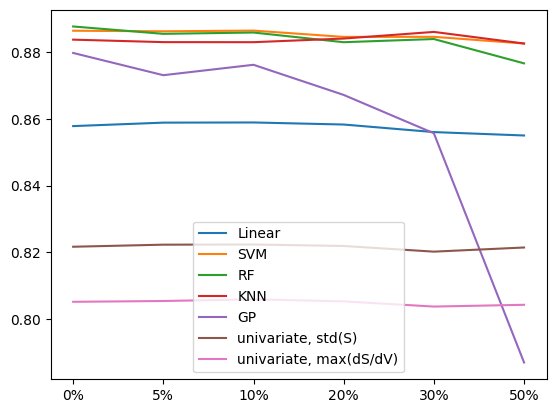

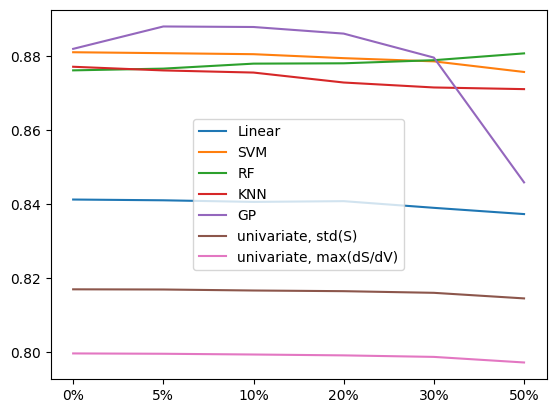

In [25]:
per_to_remove = [0, 5, 10, 20, 30, 50]
model_names_to_test = ['Linear', 'SVM', 'RF', 'KNN', 'GP', 'univariate, std(S)', 'univariate, max(dS/dV)']
training_reduction_plot(r2_score_val.copy(),  model_names_to_test, adj_score=True)
training_reduction_plot(r2_score_test.copy(), model_names_to_test, adj_score=True)

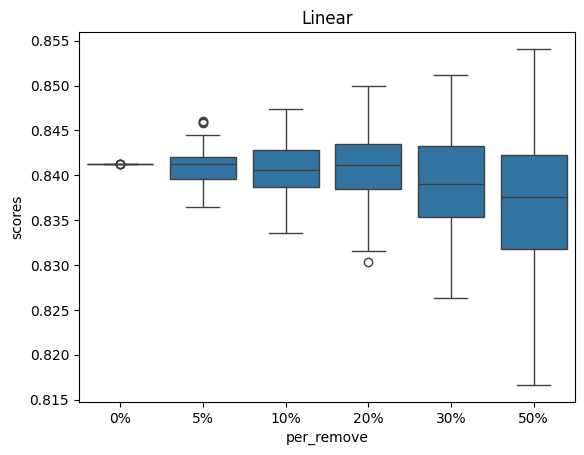

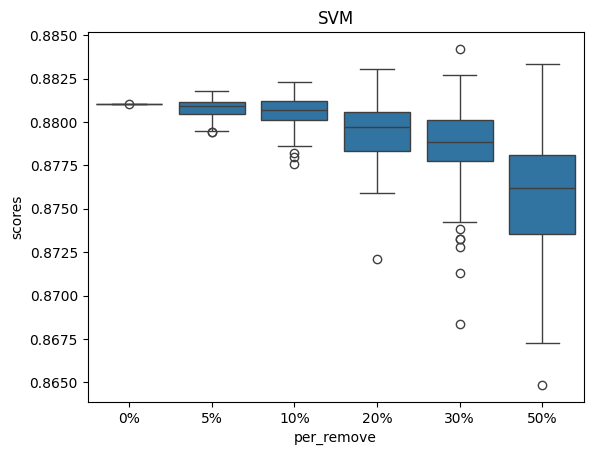

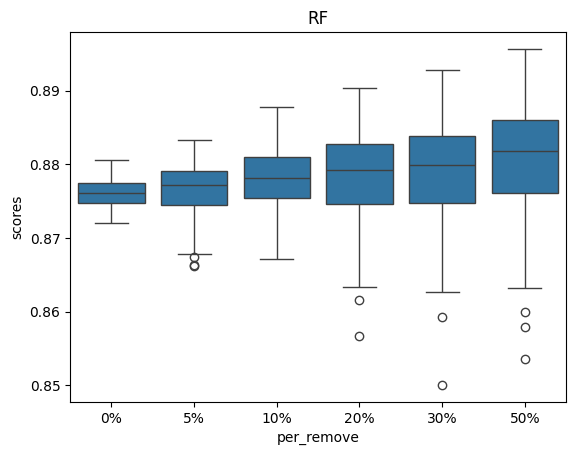

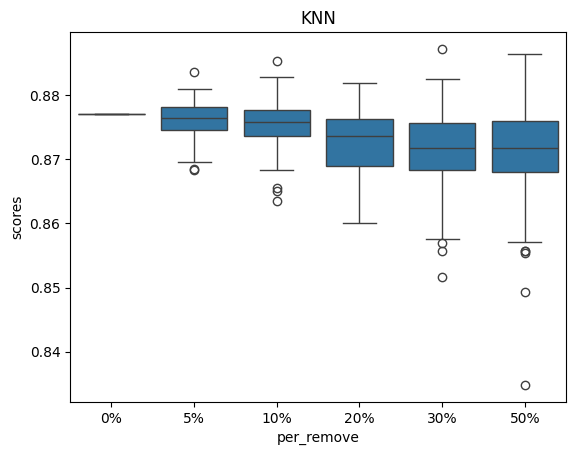

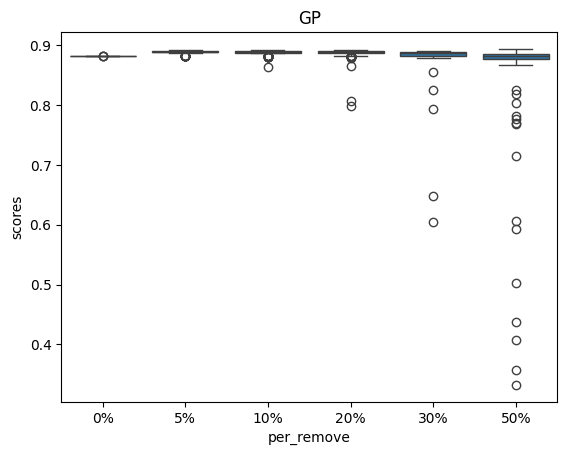

In [26]:
per_to_remove = [0, 5, 10, 20, 30, 50]
box_plot(r2_score_test.copy(), ['Linear', 'SVM', 'RF', 'KNN', 'GP'], adj_score=True)

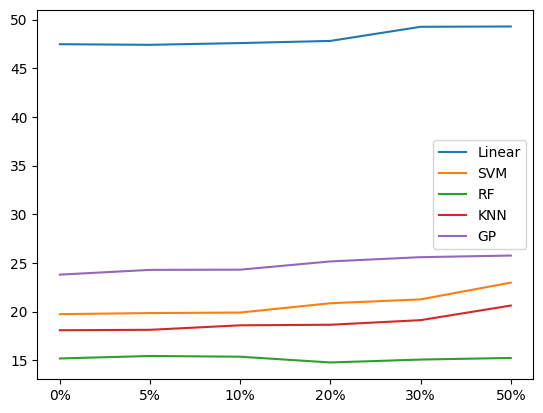

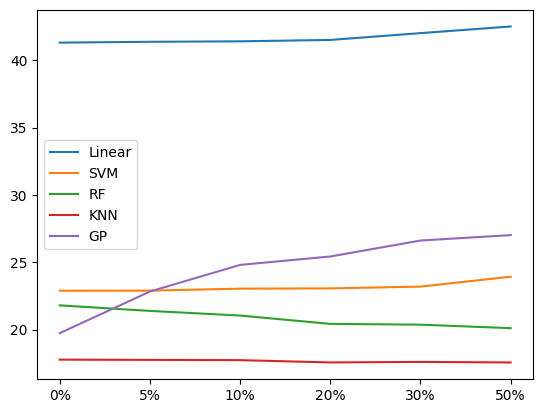

In [23]:
training_reduction_plot(per_diff_val.copy(), ['Linear', 'SVM', 'RF', 'KNN', 'GP'])
training_reduction_plot(per_diff_test.copy(), ['Linear', 'SVM', 'RF', 'KNN', 'GP'])

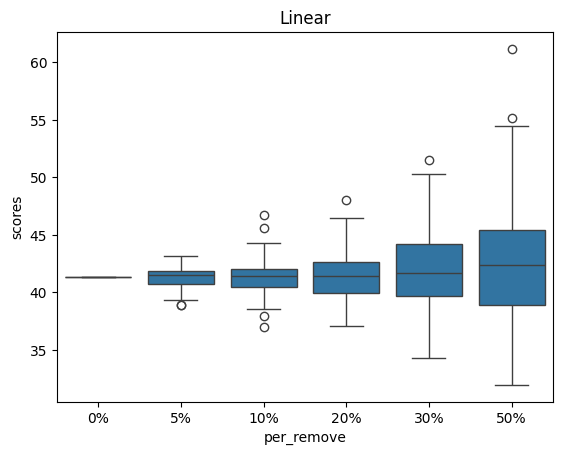

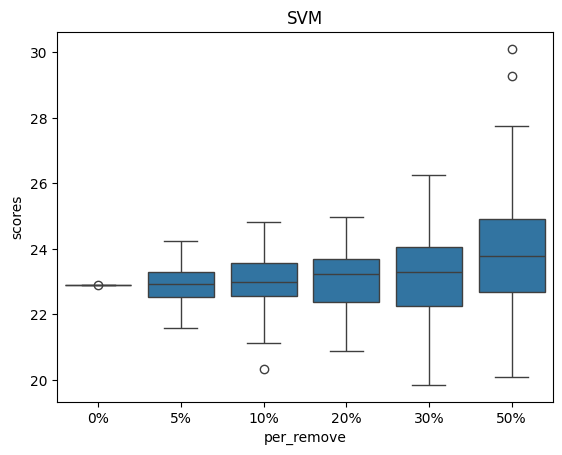

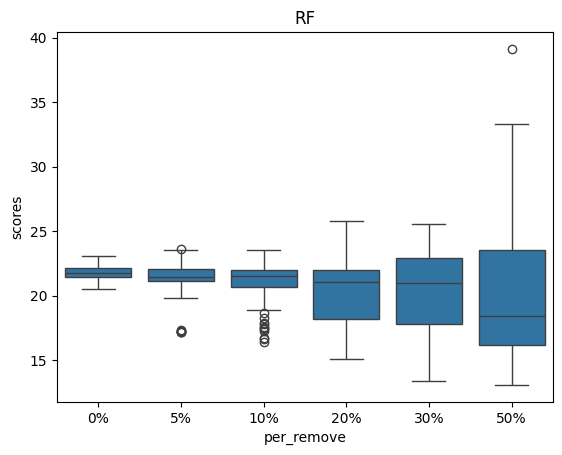

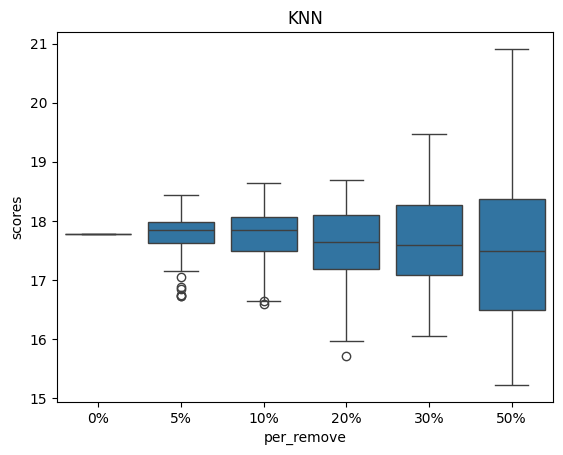

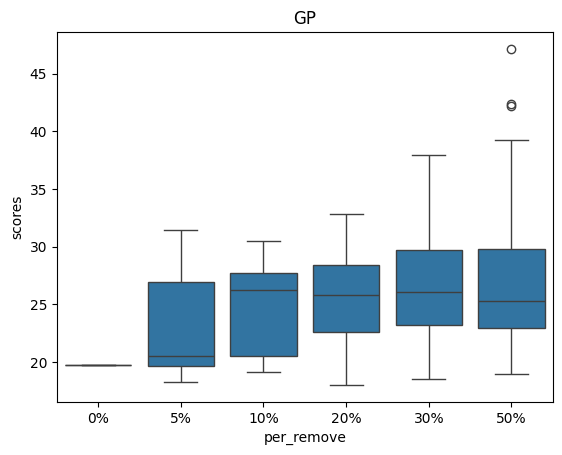

In [27]:
box_plot(per_diff_test.copy(), ['Linear', 'SVM', 'RF', 'KNN', 'GP'])

In [ ]:
plot_scores_distribution(r2_score_test.copy(), 'GP')
# plot_scores_distribution(r2_score_val.copy(), 'SVM')
# plot_scores_distribution(r2_score_val.copy(), 'RF')
# plot_scores_distribution(r2_score_val.copy(), 'KNN')

In [ ]:
# Plot KDEs with labels
model_name = 'RF'
sns.kdeplot(np.array(r2_score_test[5][model_name])[:,0], label='5%', color='r')
sns.kdeplot(np.array(r2_score_test[10][model_name])[:,0], label='10%', color='b')
sns.kdeplot(np.array(r2_score_test[20][model_name])[:,0], label='20%', color='g')
sns.kdeplot(np.array(r2_score_test[30][model_name])[:,0], label='30%', color='m')

# Add legend
plt.legend(title='Parameter', title_fontsize='13')

In [ ]:
sns.kdeplot(per_diff_test[5]['KNN'])
sns.kdeplot(per_diff_test[10]['Linear'])
sns.kdeplot(per_diff_test[20]['Linear'])
sns.kdeplot(per_diff_test[30]['Linear'])

In [8]:
# r2_score_val,  per_diff_val  = {}, {}
# r2_score_test, per_diff_test
with open('../weights/r2_score_val.pickle', 'wb') as f:
    dump(r2_score_val, f)

with open('../weights/per_diff_val.pickle', 'wb') as f:
    dump(per_diff_val, f)

with open('../weights/r2_score_test.pickle', 'wb') as f:
    dump(r2_score_test, f)

with open('../weights/per_diff_test.pickle', 'wb') as f:
    dump(per_diff_test, f)

In [ ]:
r2_score_val.keys()

In [ ]:
np.random.choice(range(5), 5,replace=False)

In [ ]:
list(range(5))

In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [20]:
X = np.array([[[1,2,3], [3,4,5]], [[3,4,5], [5,6,7]], [[5,6,7], [6,7,8]], [[6,7,8], [7,6,7]], [[7,6,7],[8,6,6]]])
y = np.array([3, 2, 3, 5, 4, 6])

In [21]:
# Define the kernel
kernel =  RBF(1.0, (1e-4, 1e1))

# Create and fit the GP model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)
gp.fit(X, y)

ValueError: Found array with dim 3. GaussianProcessRegressor expected <= 2.